In [ ]:
from src.factor.optimizer.api import PortfolioOptimizer
config_path = 'custom_opt_config.yaml'

optim = PortfolioOptimizer('quadprog')
optim.setup_optimizer(config_path)

s0 = optim.optimize(20240530)
s0


In [ ]:
s0.analytic.styler('risk')

In [ ]:
s0.port = s0.port.forward(20240606)
s1 = optim.optimize(20240606 , init_port=s0.port)
s1

In [ ]:
s1.analytic.styler('style')

In [ ]:
from src.factor.basic import RISK_MODEL
risk_model = RISK_MODEL.get(20240606)

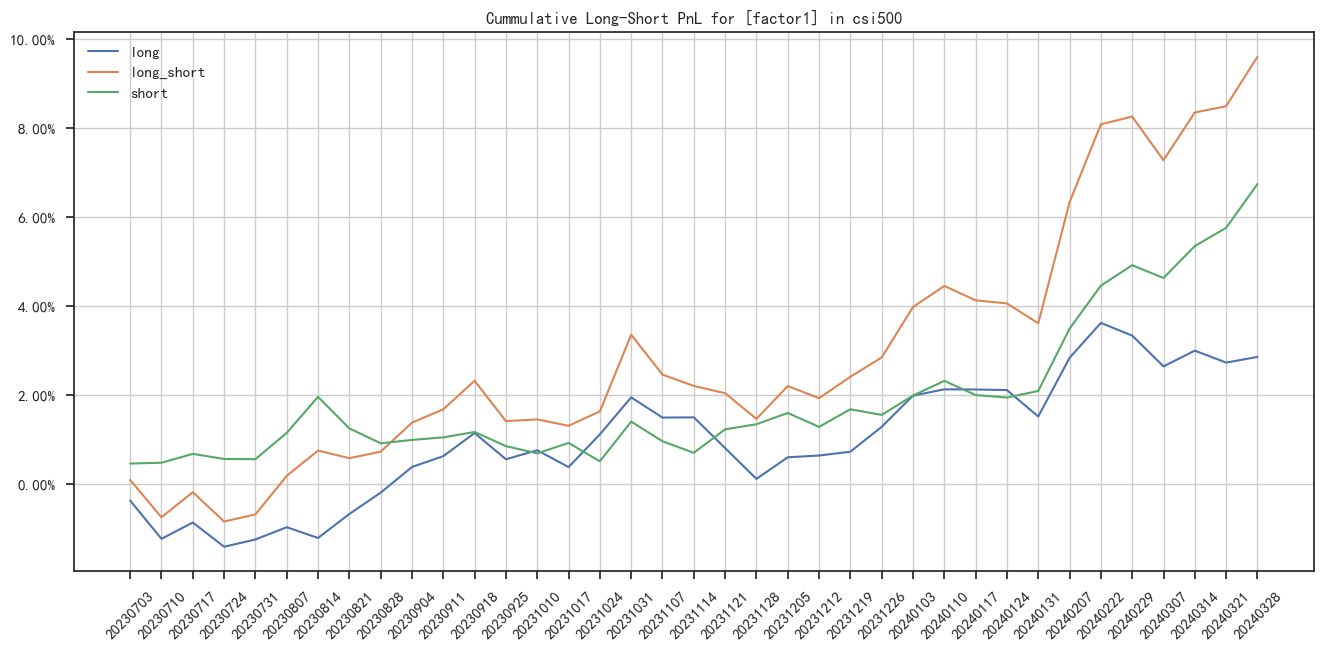

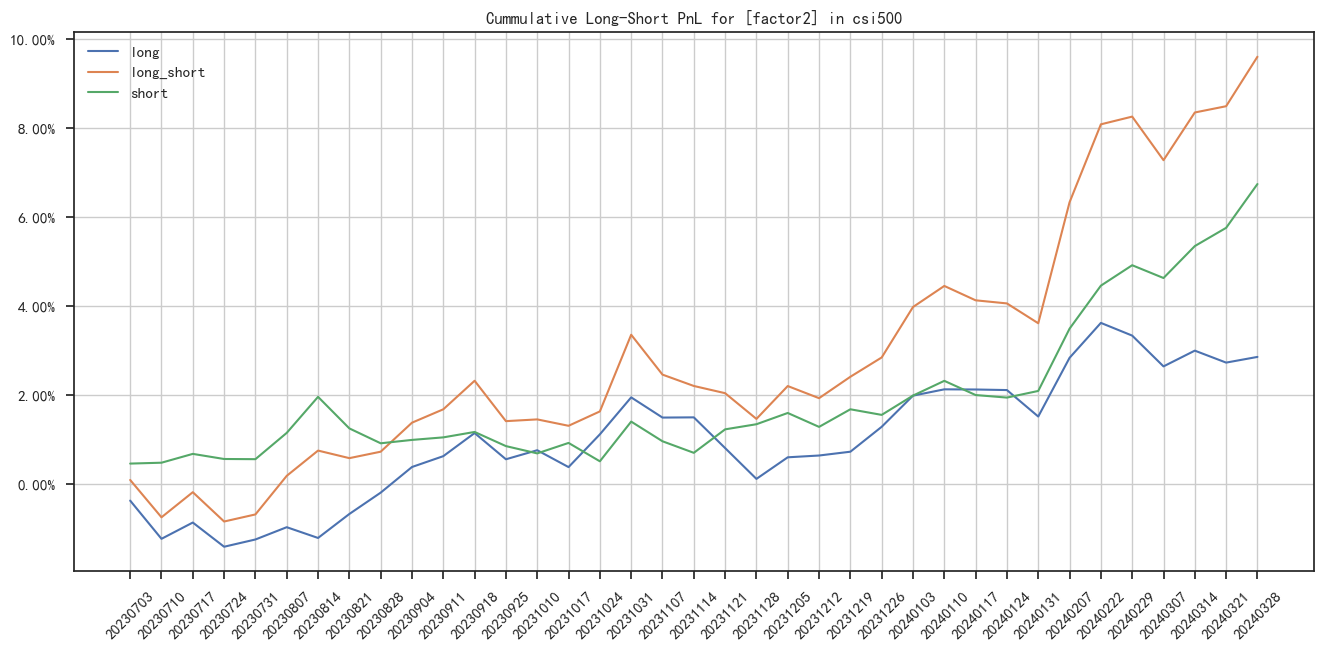

In [1]:
from src.factor.perf.api import PnLCurve , Benchmark
from src.factor.basic import DATAVENDOR , AlphaModel

factor_val = DATAVENDOR.random_factor(20230701 , 20240331 , nfactor=2).to_dataframe()
benchmark  = Benchmark('csi500')

a = PnLCurve()
fig = a.calc(factor_val , benchmark).plot(True)

In [2]:
benchmarks[0].get(model_date)

Portfolio <date=20230814> <name=csi300> <value=10000000.0> : 
      secid    weight
0    600519  0.059678
1    300750  0.032369
2    601318  0.027699
3    600036  0.021169
4       858  0.017249
..      ...       ...
295     800  0.000430
296  601236  0.000420
297  605499  0.000410
298  601698  0.000380
299    1289  0.000160

[300 rows x 2 columns]

In [4]:
from src.factor.basic import DATAVENDOR , AlphaModel , RISK_MODEL , Portfolio , BENCHMARKS
from src.factor.optimizer.api import PortfolioOptimizer , PortOptimResult

config_path  = 'custom_opt_config.yaml'

factor_val = DATAVENDOR.random_factor(20230701 , 20230930 , nfactor=2).to_dataframe()

factor_names = factor_val.columns
benchmarks = [BENCHMARKS[bm] for bm in ['csi300' , 'csi500' , 'csi1000']]

alpha_models = [AlphaModel.from_dataframe(factor_val[[factor_name]]) for factor_name in factor_names]
[RISK_MODEL.load_models(amodel.available_dates()) for amodel in alpha_models]

portfolios = [[Portfolio(f'{factor_name}_{bm.name}') for bm in benchmarks] for factor_name in factor_names]
optimizers = [[PortfolioOptimizer('linprog').setup_optimizer(pf.name , config_path) for pf in pfl] for pfl in portfolios]
results : list[list[list[PortOptimResult]]] = [[[] for _ in benchmarks] for _ in factor_names]

for i , (factor_name , alpha_model) in enumerate(zip(factor_names , alpha_models)):
    for j , model_date in enumerate(alpha_model.available_dates()[:2]):
        for bm , pf , opt , rslt in zip(benchmarks , portfolios[i] , optimizers[i] , results[i]):
            init_port = rslt[-1].port.forward(model_date) if rslt else None
            rslt.append(opt.optimize(model_date , alpha_model , bm , init_port))
            pf.append(rslt[-1].port)
            print(f'Done {pf.name} at {model_date} , time cost : {rslt[-1].time}')


Done factor1_csi300 at 20230703 , time cost : {'parse_input': 0.03499794006347656, 'solve': 0.09376978874206543, 'output': 0.016738414764404297}
Done factor1_csi500 at 20230703 , time cost : {'parse_input': 0.019858121871948242, 'solve': 0.08035778999328613, 'output': 0.016680479049682617}
Done factor1_csi300 at 20230710 , time cost : {'parse_input': 0.029345035552978516, 'solve': 0.18327069282531738, 'output': 0.019156694412231445}
Done factor1_csi500 at 20230710 , time cost : {'parse_input': 0.022347450256347656, 'solve': 0.14574289321899414, 'output': 0.03190207481384277}
Done factor2_csi300 at 20230703 , time cost : {'parse_input': 0.019598007202148438, 'solve': 0.08167672157287598, 'output': 0.016716480255126953}
Done factor2_csi500 at 20230703 , time cost : {'parse_input': 0.031876325607299805, 'solve': 0.0847468376159668, 'output': 0.01717972755432129}
Done factor2_csi300 at 20230710 , time cost : {'parse_input': 0.022905826568603516, 'solve': 0.16405200958251953, 'output': 0.01

In [2]:
factor_val.columns

Index(['factor1', 'factor2'], dtype='object')

In [24]:
import numpy as np
w = np.random.randn(10)
eps = 1e-6
w * ((w >= eps) + (w <= -eps))

array([-0.8675951 ,  0.30637829,  0.85537999, -0.61488844,  0.9082275 ,
       -0.3462642 , -1.33596834,  0.10636574, -0.89465353, -0.32940181])

In [19]:
opt.opt_input.w0

In [16]:
opt.optimize(model_date , alpha_model , bm , init_port)

PortOptimResult ---------- 
Information : 
    is_success = True ,
    status     = optimal ,
Result : 
    utility    = Utility(Total Utility=[0.0000],alpha=[0.0000],short=[0.0000])
    accuracy   = Accuarcy(Is Accurate=[True] ,,
          lin_ub_bias=(X)-0.46058485632805507,
          lin_lb_bias=(X)-1.0,
          bnd_ub_bias=(√)0.0,
          bnd_lb_bias=(X)-0.02655887044966221
Portfolio <date=20230703> <name=factor1_csi300> <value=10000000.0>: 
Empty DataFrame
Columns: [secid, weight]
Index: []
Analytic : (Only show style , access industry/risk mannually)
 portfolio benchmark active
style   
size 0.0000 0.9020 -0.9020
beta 0.0000 0.0972 -0.0972
momentum 0.0000 -0.2933 0.2933
residual_volatility 0.0000 -0.1639 0.1639
non_linear_size 0.0000 -0.5135 0.5135
book_to_price 0.0000 -0.0758 0.0758
liquidity 0.0000 0.0075 -0.0075
earnings_yield 0.0000 0.2536 -0.2536
growth 0.0000 0.2597 -0.2597
leverage 0.0000 0.1707 -0.1707

Other components include ['w' , 'secid'])

In [2]:
init_port

Portfolio <date=20230925> <name=factor1_csi300> <value=10000000.0>: 
Empty DataFrame
Columns: [secid, weight, adjfactor_x, close_x, adjfactor_y, close_y]
Index: []

In [5]:
s0.port.name

'port'

In [3]:
portfolio = Portfolio(f'{alpha_model.name}_opt_port')

NameError: name 'Portfolio' is not defined

In [2]:
alpha_model.name

'Alpha0'